## Summary
HeatmapX began as an attempt to represent geospatial data more faithfully in heatmaps, so let's start with a simple example from this domain!
Below we'll visualize how easy it is to drive from four points of interest in London to their surroundings.
Along the way, you'll see how to feed data from an [OSMnx](https://geoffboeing.com/publications/osmnx-complex-street-networks/) street network into HeatmapX.

### Pre-Requisites (Imports & OSMnx Configuration)

In [1]:
from copy import deepcopy
from typing import Any

import geocoder
import matplotlib as mpl
import matplotlib.pyplot as plt

import heatmapx as hx
import networkx as nx
import osmnx as ox

ox.settings.use_cache = True
ox.settings.log_console = True

## Defining an OSMnx Network

We'll consider the free-flow travel times by car from four points of interest to streets within $2000$ meters in the London area.

In [2]:
poi_addresses = [
    'Buckingham Palace, London SW1A 1AA, United Kingdom',
    'Trafalgar Square, London WC2N 5DN, United Kingdom',
    'The London Eye, Westminster Bridge Road, London SE1 7PB, United Kingdom',
    '21 New Globe Walk, London SE1 9DT, United Kingdom'  # The Globe Theatre
]

poi_radius = 2000  # in meters

G = nx.compose_all([
    ox.graph_from_address(
        point_of_interest,
        dist=poi_radius,
        network_type='drive',
        simplify=True
    )
    for point_of_interest in poi_addresses
])

G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

We'll also use need to know where our points of interest are actually located in the graph `G`.
The easiest (although sometimes less precise) way to do so is to geocode each address and have OSMnx map its coordinates to a location within the network.

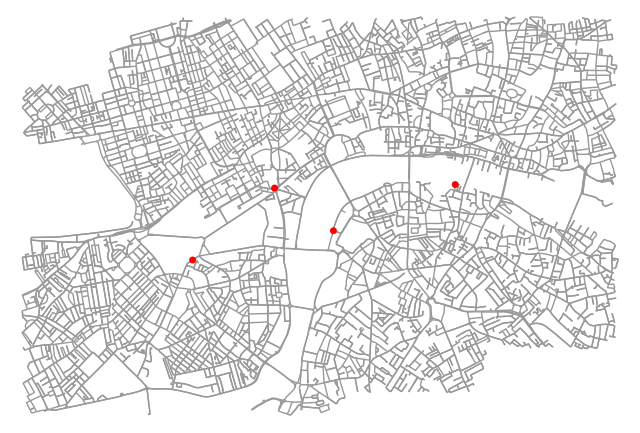

In [3]:
def find_nearest_node(G, address) -> Any:
    address_longlat = (
        geocoder.osm(address).geojson['features'][0]['geometry']['coordinates']
    )
    return ox.nearest_nodes(G, *address_longlat)

poi_nodes = [find_nearest_node(G, address) for address in poi_addresses]

ox.plot_graph(
    G,
    node_size=[25 if node in poi_nodes else 0 for node in G.nodes],
    node_color=['r' if node in poi_nodes else 'gray' for node in G.nodes],
    bgcolor='#FFFFFF'
);

## Computing Distances from Source Nodes
At present, HeatmapX doesn't include built-in features for network distance calculations, so we'll need to calculate the distances from the points of interest to the other edges and nodes in the diagram.
(If you would take advantage of this functionality, please [let us know!](https://github.com/drmrd/heatmapx/issues))
The most intuitive approach for nodes in the network is to assign each of them its distance to the _nearest_ point of interest, and NetworkX makes this sort of calculation a piece of cake.
HeatmapX will handle factoring in the other nodes later.

In [4]:
path_lengths_from_sources = {
    source: nx.shortest_paths.single_source_dijkstra_path_length(
        G, source, weight='travel_time'
    )
    for source in poi_nodes
}

nx.set_node_attributes(
    G,
    name='distance',  # The distance to the nearest point of interest.
    values={
        target: min(
            path_lengths_from_sources[source].get(target, float('inf'))
            for source in poi_nodes
        )
        for target in G.nodes
    }
)

For edges, however, we have more choices available regarding what makes the most sense as a distance (or set of distances) to record.
Ideally, we would track the distance to the nearest point of interest for each edge's initial and terminal node and then interpolate along the rest of the edge, producing a color gradient rather than a fixed value along its length.
Of course, this isn't a feature on the radar for OSMnx, and its `plot_graph` function isn't equipped to handle that kind of interpolated color scheme.

Rather than filling this example with a rather complex set of Matplotlib manipulations to implement this sort of edge gradient interpolation scheme ourselves, we'll just assign to each edge the average of its initial and terminal nodes' distances to the points of interest and let `ox.plot_graph` handle the rest.
(Again, we are considering adding support for this in HeatmapX [if there is interest](https://github.com/drmrd/heatmapx/issues).)

In [5]:
nx.set_edge_attributes(G, name='mean_distance', values=float('inf'))

for *edge, travel_time in G.edges(keys=True, data='travel_time'):
    start, *_ = edge
    G.edges[edge]['mean_distance'] = (
        G.nodes[start]['distance'] + travel_time / 2
    )

## Generating a Heatmap
We're now to where HeatmapX comes into the picture.
With distances assigned to the graph's edges, computing the data for a heatmap is as simple as calling the `heat_graph_with_increments` function.

In [6]:
T = hx.heat_graph_with_increments(G, sources=poi_nodes, weight=f'mean_distance')

The graph `T` is a copy of `G` without data except for its `mean_distance` attribute and a new attribute called `heat` storing, you guessed it, the heat computed by the `heat_graph_with_increments` function for each node and edge.
We can take advantage of the `plot_graph` function provided by OSMnx after copying over the geometry data from `G` and the [CRS](https://en.wikipedia.org/wiki/Spatial_reference_system) stored in its `graph` attribute dictionary.

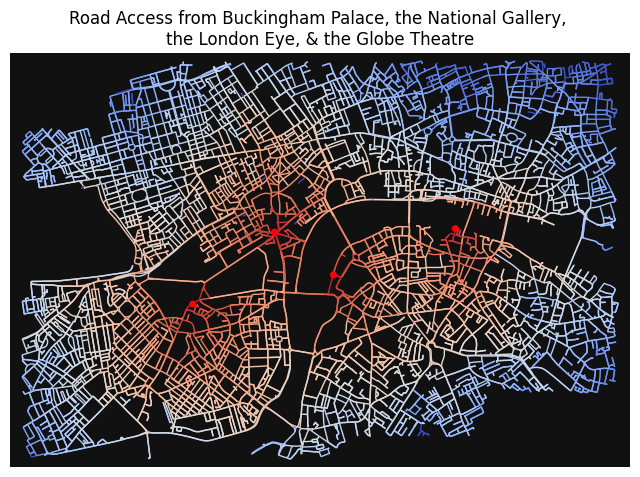

In [7]:
T.graph = deepcopy(G.graph)
nx.set_edge_attributes(
    T,
    nx.get_edge_attributes(G, 'geometry'),
    'geometry'
)
for coordinate in ['x', 'y']:
    nx.set_node_attributes(
        T,
        nx.get_node_attributes(G, coordinate),
        coordinate
    )

cmap = mpl.cm.get_cmap('coolwarm')
node_travel_times = [heat for _, heat in T.nodes.data('heat')]
edge_travel_times = [heat for *_, heat in T.edges.data('heat')]
heat_normalizer = mpl.colors.Normalize(
    vmin=min(*node_travel_times, *edge_travel_times),
    vmax=max(*node_travel_times, *edge_travel_times)
)

fig, ax = ox.plot_graph(
    T,
    show=False,
    node_size=[25 if node in poi_nodes else 0 for node in T.nodes],
    node_color=['red' if node in poi_nodes else 'gray' for node in T.nodes],
    edge_color=[cmap(1 - heat_normalizer(temp))
                for start, _, temp in T.edges(data='heat')]
)

ax.set_title('Road Access from Buckingham Palace, the National Gallery, '
             '\nthe London Eye, & the Globe Theatre')
plt.show()

And there we have it!
In less than $60$ lines of code we've taken an OSMnx graph and visualized the travel times from tourist attractions in London to all nearby locations.
And we did so while respecting the complexity of the road network!
Notice, for instance, how there are blue streets amid the deep red near the rightmost source node (the Globe Theatre), indicating that a more circuitous path is required to reach those locations than some of its neighbors.
A close inspection will also reveal edges that are dark blue amid red and lighter blue edges.
One such edge appears to the northeast of the second-to-the-leftmost source node (the National Gallery), for instance.
These frequently indicate one-way access points that are unreachable from all source nodes or (when along the boundary of the network) where we have arbitrarily cut-off a section of the road network when restricting to a bounding box.
In either case, HeatmapX addresses these (_ahem_) edge cases intelligently.